In [1]:
import sys
import os
import pandas as pd
sys.path.append('..')
sys.path.append('../src')
sys.path.append('../data')
# from Src.config import hf_access_token, hf_model_cache_dir # noqa: E402
# os.environ["HF_HOME"] = hf_model_cache_dir 
# import torch

%load_ext autoreload
%autoreload 2

Load the model "gpt2" or "EleutherAI/pythia-6.9b"

In [2]:
from Src.model import ModelFactory
model = ModelFactory.create("gpt2")

/home/viki/miniconda3/envs/fact/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2 into HookedTransformer


Then load the dataset (Warning, select the right dataset for the model you loaded). Load also the ablator class


In [3]:
from Src.dataset import BaseDataset
from Src.experiment import Ablator


dataset = BaseDataset(path = "../data/full_data_sampled_gpt2.json",
                      model = model,
                      experiment="copyVSfact",
                      no_subject=True)
ablator = Ablator(model=model, dataset=dataset, experiment="copyVSfact", batch_size=20)

 No subject found in the dataset , proceeding with no subject data


Tokenizing and computing lengths: 100%|██████████| 10000/10000 [02:37<00:00, 63.47it/s]


Set the heads that you want to modify, the value to multiply the heads and the token position that you want to modify (all, or attribute):

In [4]:
cofa_heads = [(7, 10), (9, 9), (9, 6), (10, 1)]
fa_heads = [(10, 7), (11, 10)]

cofa_alphas = [1, 1/2, 1/5, 1/10, 0]
fa_alphas = [0, 1, 2, 5, 10, 100]

Run the attention modification:


- mem --> logit of the factual token


- cp --> logit of the counterfactual token

- mem win --> number of factual predictions

- cp win --> number of counterfactual predictions

In [5]:
result_boost = []
for alpha in fa_alphas:
    ablator.set_heads(heads=fa_heads, value=alpha, position="attribute")
    result_boost.append(ablator.run())

Ablating: 100%|██████████| 24/24 [01:44<00:00,  4.34s/it]


In [6]:
result_surpress = []
for alpha in cofa_alphas:
    ablator.set_heads(heads=cofa_heads, value=alpha, position="attribute")
    result_surpress.append(ablator.run())

Ablating:   0%|          | 0/24 [00:00<?, ?it/s]

Ablating: 100%|██████████| 24/24 [02:38<00:00,  6.60s/it]


In [ ]:
combined_result = []
for a in cofa_alphas[1:]:
    for b in fa_alphas:
        ablator.set_heads(heads=cofa_heads, value=a, position="attribute")
        ablator.set_heads(heads=fa_heads, value=b, position="attribute", reset=False)
        combined_result.append(ablator.run())

Ablating:   0%|          | 0/24 [00:00<?, ?it/s]

Ablating:   4%|▍         | 1/24 [00:21<08:25, 21.97s/it]

In [9]:
# merge all results into one df
data_boost = pd.concat(result_boost)
data_boost["experiment"] = "boost"
data_boost["fa_alpha"] = fa_alphas

data_surpress = pd.concat(result_surpress)
data_surpress["experiment"] = "surpress"
data_surpress["cofa_alpha"] = cofa_alphas

data_combined = pd.concat(combined_result)
data_combined["experiment"] = "combined"
data_combined["cofa_alpha"] = cofa_alphas[1:]
data_combined["fa_alpha"] = 5

data = pd.concat([data_boost, data_surpress, data_combined])
data = data.reset_index(drop=True)
data['percentage'] = data['mem_win'] / (data['mem_win'] + data['cp_win']).astype(float)

data

,mem,cp,diff,mem_std,cp_std,diff_std,mem_win,cp_win,experiment,fa_alpha,cofa_alpha,percentage
0,14.024076,19.459356,-5.435279,1.795781,2.724508,2.831402,67.0,9928.0,boost,0.0,NaN,0.006703
1,13.981473,17.561539,-3.580064,1.674214,2.685192,2.665300,413.0,9547.0,boost,1.0,NaN,0.041466
2,13.947168,15.336195,-1.389028,1.637497,2.689529,2.649626,3218.0,6553.0,boost,2.0,NaN,0.329342
3,13.857364,14.130378,-0.273015,1.666047,2.702236,2.729101,5014.0,4614.0,boost,5.0,NaN,0.520773
4,13.839895,13.989985,-0.150091,1.663305,2.688327,2.742588,5156.0,4456.0,boost,10.0,NaN,0.536413
5,13.831625,13.926047,-0.094424,1.660842,2.670365,2.741903,5229.0,4374.0,boost,100.0,NaN,0.544517
6,13.981473,17.561539,-3.580064,1.674214,2.685192,2.665300,413.0,9547.0,surpress,NaN,1.0,0.041466
7,14.634983,17.555273,-2.920290,1.773532,2.632624,2.619529,866.0,9082.0,surpress,NaN,0.5,0.087053
8,14.811366,17.460604,-2.649238,1.817922,2.562913,2.565062,1092.0,8850.0,surpress,NaN,0.2,0.109837
9,14.841087,17.440123,-2.599036,1.825139,2.550021,2.555398,1156.0,8786.0,surpress,NaN,0.1,0.116274


In [10]:
data.to_csv("../data/ablation_results.csv", index=False)

In [ ]:
ablator.set_heads(heads=cofa_heads, value=a, position="attribute")
ablator.set_heads(heads=fa_heads, value=5, position="attribute", reset=False)
combined_result.append(ablator.run())


[0.04146586345381526, 0.08705267390430237, 0.5207727461570419, 0.6899789029535865]


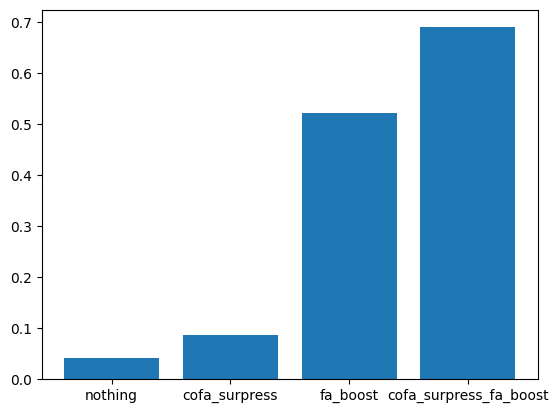

In [ ]:
# plot the bar plot with keys as x axis and percentage value as y axis
import matplotlib.pyplot as plt

plt.bar(res.keys(), [v['percentage'] for v in res.values()])
plt.show()


## Use your own modification

You can pass to the model your own modification function. You can pass a list of hook (string, function) to the model using set_hooks method. The hooks should be consistent with the hook of the transformer lens library (https://neelnanda-io.github.io/TransformerLens/index.html)